# **Hệ gợi ý**
**Tập dữ liệu MovieLens**

Bộ dữ liệu MovieLens là một bộ dữ liệu phổ biến trong bài toán hệ gợi ý. MovieLens là một hệ thống giới thiệu phim dựa trên website phi thương mại. Nó được tạo ra vào năm 1997 và được điều hành bởi GroupLens, một phòng thí nghiệm nghiên cứu tại Đại học Minnesota, nhằm thu thập dữ liệu đánh giá phim cho mục đích nghiên cứu. 

# **1. Cài đặt thư viện và chuẩn bị dữ liệu**

In [ ]:
!pip install --quiet cornac==1.5.2

     |████████████████████████████████| 7.0 MB 4.7 MB/s 


In [ ]:
import os
import sys
import textwrap
from collections import defaultdict
import itertools

import scipy.sparse as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN
from cornac.models import MF, NMF, BaselineOnly

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

SEED = 42
VERBOSE = False

System version: 3.8.15 (default, Oct 12 2022, 19:14:39) 
[GCC 7.5.0]
Cornac version: 1.5.2


In [ ]:
data = cornac.datasets.movielens.load_feedback(variant="100K")
rates = pd.DataFrame(data, columns=["user_id", "item_id", "rating"])

Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.data
will be cached into /root/.cornac/ml-100k/u.data


0.00B [00:00, ?B/s]

File cached!


In [ ]:
# Download some information of MovieLens 100K dataset
user_df = pd.read_csv(
  cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.user"), 
  sep="|", names=["UserID", "Age", "Gender", "Occupation", "Zip Code"]
).set_index("UserID")

Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.user
will be cached into /root/.cornac/u.user


0.00B [00:00, ?B/s]

File cached!


In [ ]:
item_df = pd.read_csv(
  cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.item"), 
  sep="|", encoding="ISO-8859-1",
  names=["ItemID", "Title", "Release Date", "Video Release Date", "IMDb URL", 
         "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", 
         "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", 
         "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
).set_index("ItemID").drop(columns=["Video Release Date", "IMDb URL", "unknown"])

Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.item
will be cached into /root/.cornac/u.item


0.00B [00:00, ?B/s]

File cached!


# **2. Phân tích dữ liệu**

**Dữ liệu thông tin người dùng**

In [ ]:
user_df.head()

,Age,Gender,Occupation,Zip Code
UserID,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


In [ ]:
user_df.describe()

,Age
count,943.000000
mean,34.051962
std,12.192740
min,7.000000
25%,25.000000
50%,31.000000
75%,43.000000
max,73.000000


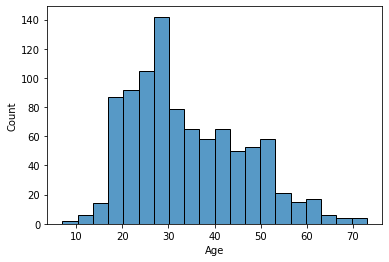

In [ ]:
sns.histplot(data=user_df, x="Age", bins=20)

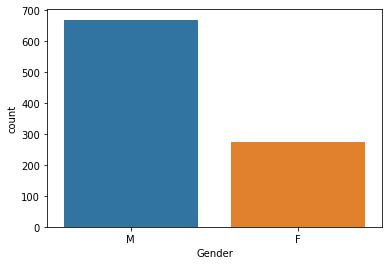

In [ ]:
sns.countplot(data=user_df, x='Gender')

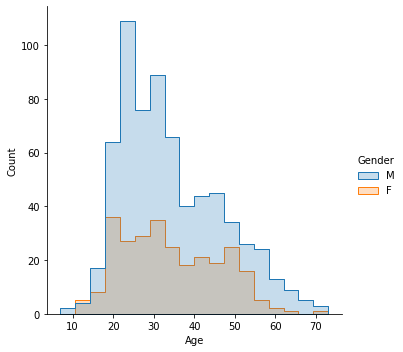

In [ ]:
sns.displot(user_df, x="Age", hue="Gender",  element="step")

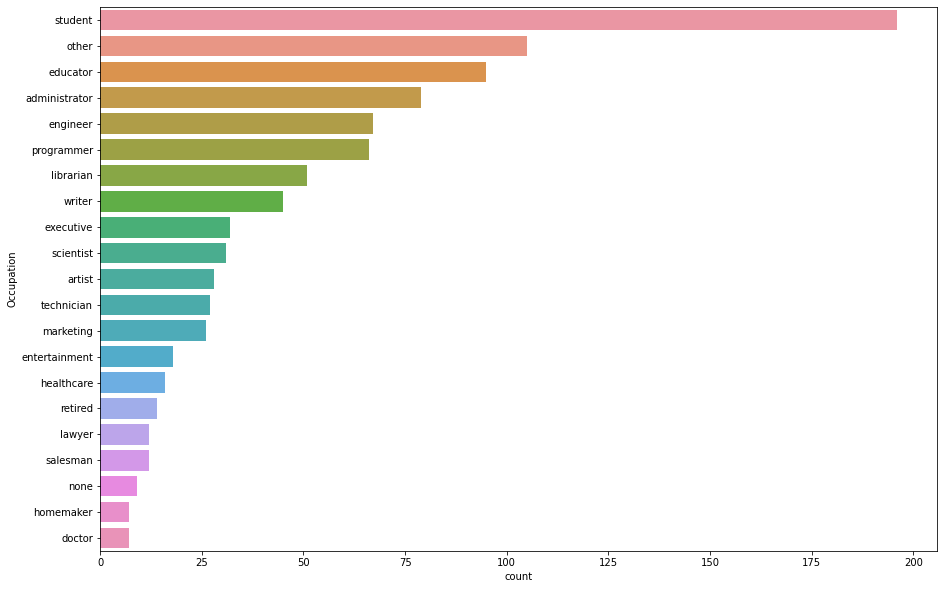

In [ ]:
fig, axes = plt.subplots(figsize=(15, 10))
sns.countplot(data=user_df, y='Occupation', order = user_df['Occupation'].value_counts().index)

**Dữ liệu thông tin phim**

In [ ]:
item_df.head()

,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
genres = item_df[item_df.columns.difference(['Title'])].sum(axis=0)
genres = pd.DataFrame({'Genres':genres.index, 'count':genres.values})

<ipython-input-14-4bee234f7177>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  genres = item_df[item_df.columns.difference(['Title'])].sum(axis=0)


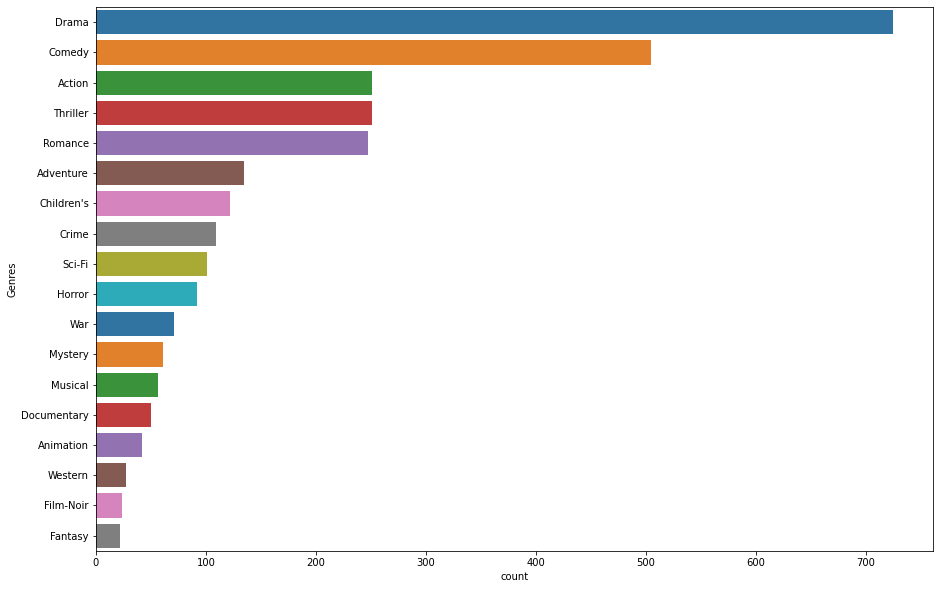

In [ ]:
fig, axes = plt.subplots(figsize=(15, 10))
sns.barplot(x="count", y="Genres", data=genres.sort_values(by=['count'], ascending=False), palette="tab10")

**Dữ liệu đánh giá**

Hầu hết thời gian chúng ta sẽ thấy từng phiên bản trong bộ dữ liệu đề xuất được biểu thị dưới dạng bộ ba (user_id, item_id, rating). Đối với tập dữ liệu MovieLens này, các giá trị đánh giá nằm trong khoảng {1, 2, 3, 4, 5}.
Các ví dụ về tập dữ liệu. Một số thống kê về dữ liệu bao gồm: số lượng mẫu, số lượng người dùng, số lượng phim, ..., các biểu đồ phân bố xác suất. 

In [ ]:
rates.head()

,user_id,item_id,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [ ]:
rates.rating.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

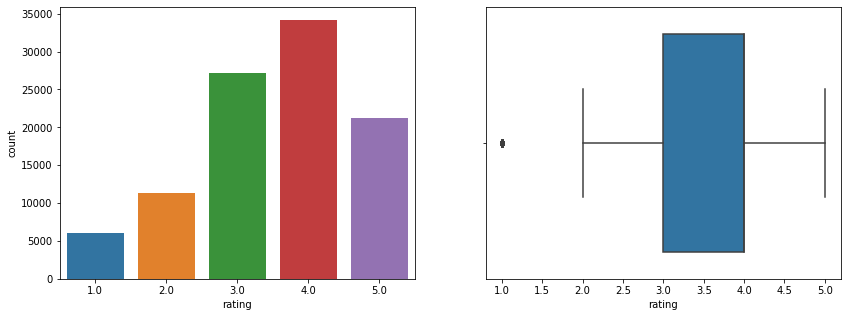

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.countplot(x="rating", data=rates, palette="tab10", ax=axes[0])
sns.boxplot(x="rating", data=rates, palette="tab10", ax=axes[1])

Chúng ta có thể vẽ các giá trị đánh giá này để xem nó được phân phối như thế nào.

Hình đầu tiên hiển thị biểu đồ về tần suất của mỗi đánh giá.
Hình thứ 2 mô tả phân phối tương tự ở dạng biểu đồ hộp.
Nói chung, hơn 50% giá trị đánh giá nằm trong khoảng {3, 4}, đánh giá 5 cũng phổ biến, trong khi {1, 2} ít có khả năng hơn.

In [ ]:
n_users = rates.user_id.nunique()
n_items = rates.item_id.nunique()
n_ratings = len(rates)
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%")

Number of users: 943
Number of items: 1682
Number of available ratings: 100000
Number of all possible ratings: 1586126
----------------------------------------
SPARSITY: 93.70%


Độ thưa thớt của dữ liệu là thước đo lượng dữ liệu chúng ta không quan sát được. Nó thường là một thách thức trong việc học từ dữ liệu. Mối quan tâm là liệu chúng ta có đủ thông tin để xây dựng một mô hình có thể nắm bắt chính xác sự phân bố chung của dữ liệu hay không.

Đối với các hệ thống đề xuất nói riêng, độ thưa thớt của dữ liệu được biểu thị bằng số lượng đánh giá bị thiếu chia cho tổng số đánh giá có thể có. Tổng số này là số lượng người dùng nhân với số lượng phim. Trong nhiều bộ dữ liệu gợi ý, người dùng chỉ đưa ra đánh giá cho một số phim hạn chế.

Một hiện tượng khác quan trọng và khá phổ biến trong hệ gợi ý là long-tail, có nghĩa là một số mục rất phổ biến và được người dùng đánh giá thường xuyên, trong khi hầu hết các mục khác được rất ít người dùng đánh giá.

Đầu tiên, chúng ta đếm số lượng đánh giá phim, những phim được đánh giá nhiều nhất và ít nhất: 

In [ ]:
item_rate_count = rates.groupby("item_id")["user_id"].nunique().sort_values(ascending=False)
item_rate_count.head(10)

item_id
50     583
258    509
100    508
181    507
294    485
286    481
288    478
1      452
300    431
121    429
Name: user_id, dtype: int64

In [ ]:
item_rate_count.tail(10)

item_id
1580    1
1581    1
1582    1
1583    1
1584    1
1586    1
1587    1
1363    1
1364    1
1604    1
Name: user_id, dtype: int64

Dưới đây chúng ta trực quan hóa thông tin đếm đánh giá:


*   Con số đầu tiên cho thấy số lượng đánh giá của mỗi phim. Các phim được sắp xếp theo giá trị giảm dần của số lượng đánh giá. Do đó, phim phổ biến nhất nằm ngoài cùng bên trái. Hình dạng đuôi dài được thảo luận trước đó là hiển nhiên.
*   Hình thứ 2 là biểu đồ log-log thể hiện mối quan hệ giữa số lượng đánh giá và số lượng phim (cả hai đều theo thang logarit). Mối quan hệ là tuyến tính tiệm cận, đó là đặc điểm chính của phân phối luật lũy thừa.

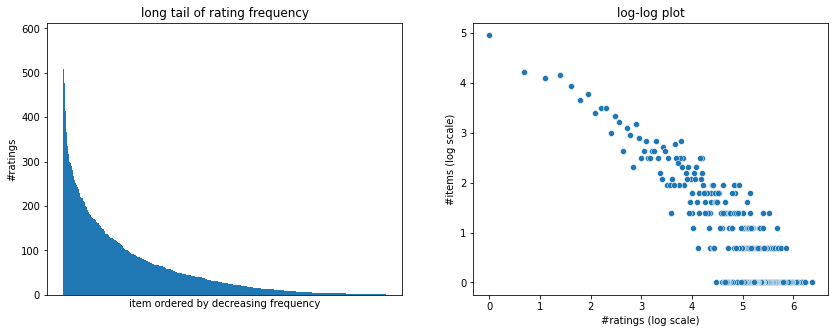

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].bar(x=item_rate_count.index, height=item_rate_count.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", 
            xlabel="item ordered by decreasing frequency", 
            ylabel="#ratings")

count = item_rate_count.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)");

In [ ]:
df_ratings = pd.DataFrame(rates.groupby('item_id')['rating'].mean())
df_ratings['total ratings'] = pd.DataFrame(rates.groupby('item_id')['rating'].count())
df_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

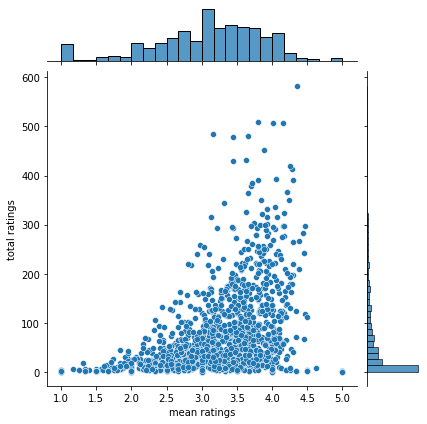

In [ ]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_ratings)

Trong biểu diễn này, điểm dữ liệu đại diện cho một phim duy nhất. Ngoài ra, có thể thấy có một mật độ rất lớn trong khu vực số lượng người dùng đánh giá 0-50 lần và giữa đánh giá trung bình 3-4.

# **3. Gợi ý dựa trên thống kê độ phổ biến** 


Vì một số phim phổ biến hơn nhiều so với những phim còn lại, nên theo trực giác, nhiều người dùng có thể thích những phim phổ biến này hơn. Từ quan sát đó, nó truyền cảm hứng cho một cách tiếp cận đơn giản để cung cấp các đề xuất dựa trên mức độ phổ biến (tức là số lượng đánh giá) của các phim.

Hãy làm một thí nghiệm đơn giản với cách tiếp cận phổ biến. Trong thử nghiệm này, chúng ta sẽ chia dữ liệu xếp hạng thành 5 phần để đánh giá chéo. Trong mỗi lần chạy, 4 phần sẽ được sử dụng để huấn luyện và phần còn lại sẽ được sử dụng để đánh giá. Chúng ta đo lường hiệu suất bằng chỉ số Recall@20.

In [ ]:
# 5-fold cross validation
eval_method = cornac.eval_methods.CrossValidation(data, n_folds=5, seed=42)

# recommender system based on item popularity
most_pop = cornac.models.MostPop()

# recall@20 metric
rec_20 = cornac.metrics.Recall(k=20)

# put everything together into an experiment
cornac.Experiment(eval_method=eval_method, models=[most_pop], metrics=[rec_20]).run()


TEST:
...
[MostPop]
       | Recall@20 | Train (s) | Test (s)
------ + --------- + --------- + --------
Fold 0 |    0.1263 |    0.0204 |   0.4667
Fold 1 |    0.1304 |    0.0057 |   0.4570
Fold 2 |    0.1337 |    0.0067 |   0.4813
Fold 3 |    0.1252 |    0.0055 |   0.4722
Fold 4 |    0.1187 |    0.0054 |   0.4468
------ + --------- + --------- + --------
Mean   |    0.1269 |    0.0087 |   0.4648
Std    |    0.0051 |    0.0058 |   0.0120



# **4. Các phương pháp gợi ý lọc cộng tác**


**Dữ liệu mẫu**

Với mục đích minh họa, chúng ta sử dụng một bộ dữ liệu đơn giản bao gồm 5 người dùng và 6 mặt hàng.

In [ ]:
sample_df = pd.read_csv(
  cache("https://static.preferred.ai/tutorials/recommender-systems/sample_data.csv"), 
  sep=",", names=["UserID", "ItemID", "Rating"]
)
sample_df.head()

Data from https://static.preferred.ai/tutorials/recommender-systems/sample_data.csv
will be cached into /root/.cornac/sample_data.csv


0.00B [00:00, ?B/s]

File cached!


,UserID,ItemID,Rating
0,1,1,7
1,1,2,6
2,1,3,7
3,1,4,4
4,1,5,5


**Dữ liệu raw**

In [ ]:
dataset = cornac.data.Dataset.from_uir(sample_df.itertuples(index=False))
df = pd.DataFrame(dataset.matrix.A,
                  index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
                  columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)])
df.replace(0, np.nan, inplace=True)
df["Mean Rating"] = df.mean(axis=1)
df

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Mean Rating
User 1,7.0,6.0,7.0,4.0,5.0,4.0,5.5
User 2,6.0,7.0,NaN,4.0,3.0,4.0,4.8
User 3,NaN,3.0,3.0,1.0,1.0,NaN,2.0
User 4,1.0,2.0,2.0,3.0,3.0,4.0,2.5
User 5,1.0,NaN,1.0,2.0,3.0,3.0,2.0


**Ma trận đánh giá trung bình**

Một mối quan tâm về dữ liệu đánh giá thường mang tính chủ quan. Đặc biệt, những người dùng khác nhau có thể có khoảng cho điểm khác nhau. Một số người dùng dễ tính có xu hướng đánh giá điểm cao hơn. Những người khó tính thường có xu hướng đánh giá thấp hơn. Một cách tiếp cận thường được áp dụng để 'bình thường hóa' đánh giá là lấy giá trị trung bình đánh giá của người dùng và trừ giá trị trung bình khỏi đánh giá cá nhân của người dùng nói trên.

In [ ]:
ratings = df[df.columns.difference(["Mean Rating"])].values
means = df["Mean Rating"].values[:, np.newaxis]
df[df.columns.difference(["Mean Rating"])] = (ratings - means)
df.drop(columns="Mean Rating")

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,1.5,0.5,1.5,-1.5,-0.5,-1.5
User 2,1.2,2.2,NaN,-0.8,-1.8,-0.8
User 3,NaN,1.0,1.0,-1.0,-1.0,NaN
User 4,-1.5,-0.5,-0.5,0.5,0.5,1.5
User 5,-1.0,NaN,-1.0,0.0,1.0,1.0


## **User-Based**

Đối với mỗi người dùng, đánh giá trung bình ấy được tính như sau:

$$ \mu_u = \frac{\Sigma_{k \in \mathcal{I}_u} r_{uk}}{|\mathcal{I}_u|} \ \ \forall u \in \{1 \dots m\} $$


Hai cách tiếp cận phổ biến để đo lường sự tương đồng giữa hai người dùng $\mathrm{Sim}(u, v)$ là *Cosine similarity* và *Pearson correlation coefficient*:

\begin{align*}
\mathrm{Cosine}(u,v) &= \frac{\Sigma_{k \in \mathcal{I}_u \cap \mathcal{I}_v} r_{uk} * r_{vk}}{\sqrt{\Sigma_{k \in \mathcal{I}_u \cap \mathcal{I}_v} r_{uk}^2} * \sqrt{\Sigma_{k \in \mathcal{I}_u \cap \mathcal{I}_v} r_{vk}^2}} \\
\mathrm{Pearson}(u,v) &= \frac{\Sigma_{k \in \mathcal{I}_u \cap \mathcal{I}_v} (r_{uk} - \mu_u) * (r_{vk} - \mu_v)}{\sqrt{\Sigma_{k \in \mathcal{I}_u \cap \mathcal{I}_v} (r_{uk} - \mu_u)^2} * \sqrt{\Sigma_{k \in \mathcal{I}_u \cap \mathcal{I}_v} (r_{vk} - \mu_v)^2}}
\end{align*}


Ví dụ: với ma trận xếp hạng ban đầu, giữa *Người dùng 1* và *Người dùng 3* chúng ta có những điểm giống nhau như sau:

\begin{align*}
\mathrm{Cosine}(1,3) &= \frac{6*3+7*3+4*1+5*1}{\sqrt{6^2+7^2+4^2+5^2} * \sqrt{3^2+3^2+1^2+1^2}} = 0.956 \\
\mathrm{Pearson}(1,3) &= \frac{(6 - 5.5) * (3 - 2) + (7 - 5.5) * (3 - 2) + (4 - 5.5) * (1 - 2) + (5 - 5.5) * (1 - 2)}{\sqrt{0.5^2 + 1.5^2 + (-1.5)^2 + (-0.5)^2} * \sqrt{1^2 + 1^2 + (-1)^2 + (-1)^2}} = 0.894
\end{align*}


In [ ]:
uknn_cosine = UserKNN(k=2, similarity="cosine", verbose=VERBOSE).fit(dataset)
print(f"Cosine(1,2) = {uknn_cosine.sim_mat[0, 1]:.3f}")

uknn_pearson = UserKNN(k=2, similarity="pearson", verbose=VERBOSE).fit(dataset)
print(f"Pearson(2,3) = {uknn_pearson.sim_mat[1, 2]:.3f}")
     

Cosine(1,2) = 0.979
Pearson(2,3) = 0.938


Chúng ta sử dụng mức trung bình có trọng số của đánh giá trung bình để đưa ra dự đoán. *prediction function* dựa trên vùng lân cận như sau:

$$ \hat{r}_{uj} = \mu_u + \frac{\Sigma_{v \in P_u(j)} \mathrm{Sim}(u,v) * (r_{vj} - \mu_v)}{\Sigma_{v \in P_u(j)} |\mathrm{Sim}(u,v)|} $$


Ví dụ: để tính đánh giá dự đoán do *User 3* đưa ra cho *Item 1* và *Item 6*, trong đó xếp hạng dựa trên hai người hàng xóm gần nhất (*User 1* và *User 2*):

\begin{align*}
\hat{r}_{31} &= 2 + \frac{1.5*0.894+1.2*0.939}{0.894 + 0.939} = 3.35 \\
\hat{r}_{36} &= 2 + \frac{-1.5*0.894-0.8*0.939}{0.894 + 0.939} = 0.86
\end{align*}


In [ ]:
print(f"R(2,3) = {uknn_pearson.score(user_idx=1, item_idx=2):.2f}")
# print(f"R(3,6) = {uknn_pearson.score(user_idx=2, item_idx=5):.2f}")

R(2,3) = 6.01


**Dữ liệu thực tế**

Bây giờ chúng ta sẽ sử dụng các thuật toán này trên bộ dữ liệu MovieLens. Quy ước của chúng ta là sử dụng xếp hạng trung bình khi tổng hợp xếp hạng của những người hàng xóm để đưa ra dự đoán và sau đó điều chỉnh giá trị trung bình. Tuy nhiên, chúng ta có thể tính toán độ tương tự dựa trên xếp hạng ban đầu hoặc xếp hạng trung bình, như thể hiện trong các biến thể bên dưới.

In [ ]:
# UserKNN methods
K = 50  # number of nearest neighbors
uknn_cosine = UserKNN(
  k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE
)
uknn_cosine_mc = UserKNN(
  k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE
)
uknn_pearson = UserKNN(
  k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE
)
uknn_pearson_mc = UserKNN(
  k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE
)

feedback = movielens.load_feedback(variant="100K")
ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split,
  models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
  metrics=[cornac.metrics.RMSE()],
).run()


TEST:
...
                   |   RMSE | Train (s) | Test (s)
------------------ + ------ + --------- + --------
UserKNN-Cosine     | 0.9102 |    0.1853 |   1.4645
UserKNN-Cosine-MC  | 0.8947 |    0.1307 |   1.4766
UserKNN-Pearson    | 0.8947 |    0.1388 |   1.6058
UserKNN-Pearson-MC | 0.8947 |    0.1394 |   1.4759



## **Item-Based**

Các điểm tương đồng *Cosine* và *Pearson* cũng có thể được áp dụng cho các phương pháp dựa trên item, ngoại trừ việc các vectơ đặc trưng hiện là cột thay vì hàng khi chúng ta đo lường mức độ tương tự giữa các item.

Nếu độ tương tự của *Cosine* dựa trên ma trận xếp hạng lấy trung bình làm trung tâm, thì chúng ta có một biến thể được gọi là *AdjustedCosine*. Độ tương tự cosine *adjusted* giữa các item (cột) *i* và *j* được xác định như sau:

$$ \mathrm{AdjustedCosine}(i,j) = \frac{\Sigma_{u \in \mathcal{U}_i \cap \mathcal{U}_j} s_{ui} * s_{uj}}{\sqrt{\Sigma_{u \in \mathcal{U}_i \cap \mathcal{U}_j} s_{ui}^2} * \sqrt{\Sigma_{u \in \mathcal{U}_i \cap \mathcal{U}_j} s_{uj}^2}} $$

trong đó $s_{ui}$ là xếp hạng tập trung vào giá trị trung bình mà người dùng $u$ dành cho item $i$.

Ví dụ: tính cosine *adjusted* giữa *item 1* và *item 3* trong tập dữ liệu mẫu nhỏ ở trên như sau:

$$ \mathrm{AdjustedCosine}(1,3) = \frac{1.5 * 1.5 + (-1.5) * (-0.5) + (-1) * (-1)}{\sqrt{1.5^2 + (-1.5)^2 + (-1)^2} * \sqrt{1.5^2 + (-0.5)^2 + (-1)^2}} = 0.912 $$

In [ ]:
iknn_adj = ItemKNN(k=2, similarity="cosine", mean_centered=True, verbose=VERBOSE).fit(dataset)
print(f"AdjustedCosine(1,3) = {iknn_adj.sim_mat[0, 2]:.3f}")

AdjustedCosine(1,3) = 0.912


Để dự đoán, sử dụng cùng một dạng hàm dự đoán như trong các phương pháp dựa trên người dùng nhưng tổng hợp xếp hạng của người dùng đối với các item lân cận:

$$ \hat{r}_{ut} = \mu_u + \frac{\Sigma_{j \in Q_t(u)} \mathrm{Sim}(j,t) * (r_{uj} - \mu_u)}{\Sigma_{j \in Q_t(u)} |\mathrm{Sim}(j,t)|} $$


Ví dụ: bên dưới, dự đoán xếp hạng mà *user 3* sẽ cung cấp cho *item 1* và *item 6*. Đánh giá cho *item 1* dựa trên hai hàng xóm gần nhất là *Item 2* và *Item 3*, trong khi đánh giá cho *Item 6* dựa trên *Item 4* và *Item 5*.

\begin{align*}
\hat{r}_{31} &= 2 + \frac{1*0.735 + 1*0.912}{0.735 + 0.912} = 3 \\
\hat{r}_{36} &= 2 + \frac{(-1)*0.829 + (-1)*0.730}{0.829 + 0.730} = 1
\end{align*}


In [ ]:
print(f"R(3,1) = {iknn_adj.score(user_idx=2, item_idx=0):.1f}")
print(f"R(3,6) = {iknn_adj.score(user_idx=2, item_idx=5):.1f}")

R(3,1) = 3.0
R(3,6) = 1.0


**Dữ liệu thực tế**

In [ ]:
# ItemKNN methods
K = 50  # number of nearest neighbors
iknn_cosine = ItemKNN(
  k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE
)
iknn_pearson = ItemKNN(
  k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE
)
iknn_pearson_mc = ItemKNN(
  k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE
)
iknn_adjusted = ItemKNN(
  k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE
)

feedback = movielens.load_feedback(variant="100K")
ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split, 
  models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
  metrics=[cornac.metrics.RMSE()],
).run()


TEST:
...
                       |   RMSE | Train (s) | Test (s)
---------------------- + ------ + --------- + --------
ItemKNN-Cosine         | 0.9687 |    0.2640 |   1.6894
ItemKNN-Pearson        | 0.9624 |    0.2410 |   1.6872
ItemKNN-Pearson-MC     | 0.9573 |    0.2412 |   1.6168
ItemKNN-AdjustedCosine | 0.9099 |    0.2254 |   1.6243



## **Tính độ tương đồng có trọng số**

Vì những điểm giống nhau của chúng ta là *Cosine* hoặc *Pearson*, nằm trong phạm vi $[-1, 1]$, nên các giá trị xếp hạng có thể khác nhau theo các tỷ lệ khác nhau trên các nền tảng khác nhau. Một thực tế phổ biến để tăng tầm quan trọng *tương đối* của điểm số tương đồng là khuếch đại hàm mũ. Ví dụ: điểm tương đồng được khuếch đại mới dựa trên tương quan *Pearson* là:

$$ \mathrm{Sim}(u, v) = \mathrm{Pearson}(u, v)^{\mathrm{amplify}} $$

Một vấn đề khác là long-tail. Một số item rất phổ biến và có xu hướng ít phân biệt với các item khác. Do đó chúng ta sẽ sử dụng tần suất nghịch đảo (idf) [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) để tính trọng số cho mỗi item, điểm 

$$ w_i = \log \bigg( \frac{N}{m_i} \bigg), $$

$N$ là số lượng người dùng và $m_i$ là số lượng đánh giá của item $i$.
ngoài ra có [Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25), một phiên bản nâng cấp của TF-IDF.


In [ ]:
# UserKNN methods
K = 50  # number of nearest neighbors
uknn_base = UserKNN(
  k=K, similarity="pearson", name="UserKNN-Base", verbose=VERBOSE
)
uknn_amp1 = UserKNN(
  k=K, similarity="pearson", amplify=0.5, name="UserKNN-Amp0.5", verbose=VERBOSE
)
uknn_amp2 = UserKNN(
  k=K, similarity="pearson", amplify=3.0, name="UserKNN-Amp3.0", verbose=VERBOSE
)
uknn_idf = UserKNN(
  k=K, similarity="pearson", weighting="idf", name="UserKNN-IDF", verbose=VERBOSE
)
uknn_bm25 = UserKNN(
  k=K, similarity="pearson", weighting="bm25", name="UserKNN-BM25", verbose=VERBOSE
)

feedback = movielens.load_feedback(variant="100K")
ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split,
  models=[uknn_base, uknn_amp1, uknn_amp2, uknn_idf, uknn_bm25],
  metrics=[cornac.metrics.RMSE()],
).run()


TEST:
...
               |   RMSE | Train (s) | Test (s)
-------------- + ------ + --------- + --------
UserKNN-Base   | 0.8947 |    0.1565 |   1.4831
UserKNN-Amp0.5 | 0.8935 |    1.6927 |   1.5319
UserKNN-Amp3.0 | 0.9134 |    0.7271 |   1.4695
UserKNN-IDF    | 0.8955 |    0.1318 |   2.7650
UserKNN-BM25   | 0.8956 |    0.1344 |   1.5249



## **Giải thích kết quả**

Thay vì đánh giá gợi ý là một nhiệm vụ hộp đen, hầu hết chúng ta sẽ thấy hữu ích nếu có thể hiểu rõ hơn lý do tại sao một số gợi ý được đưa ra. Trong nỗ lực diễn giải tốt hơn các kết quả gợi ý, chúng tôi có thể xem xét nhiều nguồn khác nhau, chẳng hạn như meta-data, đóng góp của từng item lân cận cũng như tương tác giữa người dùng và các item lân cận.

Bộ dữ liệu MovieLens 100K đi kèm với một số dạng meta-data có thể tham khảo để khám phá thêm thông tin về các gợi ý. Dưới đây chúng ta sẽ xem xét tiêu đề và thể loại phim.

**UserKNN (Pearson)**

Đối với các phương pháp UserKNN sử dụng biến thể Pearson làm hệ thống gợi ý. Trước tiên, hãy chọn một người dùng để khám phá hồ sơ cũng như các item được đánh giá cao của người dùng trong dữ liệu huấn luyện.

In [ ]:
rating_mat = uknn_pearson.train_set.matrix
user_id2idx = uknn_pearson.train_set.uid_map
user_idx2id = list(uknn_pearson.train_set.user_ids)
item_id2idx = uknn_pearson.train_set.iid_map
item_idx2id = list(uknn_pearson.train_set.item_ids)

TOPK = 5
UID = 1
UIDX = uknn_pearson.train_set.uid_map[str(UID)]

print(f"UserID = {UID}")
print("-" * 25)
print(user_df.loc[UID])

rating_arr = rating_mat[UIDX].A.ravel()
top_rated_items = np.argsort(rating_arr)[-TOPK:]
print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
item_df.loc[[int(item_idx2id[i]) for i in top_rated_items]]

UserID = 1
-------------------------
Age                   24
Gender                 M
Occupation    technician
Zip Code           85711
Name: 1, dtype: object

TOP 5 RATED ITEMS BY USER 1:


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
96,Terminator 2: Judgment Day (1991),01-Jan-1991,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
48,Hoop Dreams (1994),01-Jan-1994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
127,"Godfather, The (1972)",01-Jan-1972,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
150,Swingers (1996),18-Oct-1996,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
16,French Twist (Gazon maudit) (1995),01-Jan-1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


Chẳng hạn, trong số 5 bộ phim được xếp hạng cao nhất được quan sát cho Người dùng 1, 2 trong số đó là phim Drama.

Các đề xuất cho người dùng này có thể thu được như sau:

In [ ]:
recommendations, scores = uknn_pearson.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UID}:")
print("Scores:", scores[recommendations[:TOPK]])
item_df.loc[[int(item_idx2id[i]) for i in recommendations[:TOPK]]]


TOP 5 RECOMMENDATIONS FOR USER 1:
Scores: [6.11605904 5.48557688 5.32202542 5.30147822 5.09619216]


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
1309,"Very Natural Thing, A (1974)",01-Jan-1974,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
814,"Great Day in Harlem, A (1994)",01-Jan-1994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1536,Aiqing wansui (1994),22-Jul-1996,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Nó tiết lộ rằng trong số năm bộ phim được dự đoán, ba trong số đó là phim Drama.

Để hiểu rõ hơn về bản chất của đề xuất này, chúng ta xem những người hàng xóm gần nhất của người dùng đóng góp như thế nào vào dự đoán của từng bộ phim.

In [ ]:
df = defaultdict(list)
sim_arr = uknn_pearson.sim_mat[UIDX].A.ravel()
for rec in recommendations[:TOPK]:
  rated_users = np.array([u for u in range(len(sim_arr)) if rating_mat[u, rec] != 0])
  nearest_neighbor = rated_users[np.argsort(sim_arr[rated_users])[-1:]].item()
  sim = sim_arr[nearest_neighbor]
  score = uknn_pearson.iu_mat[rec, nearest_neighbor]
  df["Recommendation"].append(item_df.loc[[int(item_idx2id[rec])]]["Title"].values[0])
  df["User NN"].append(nearest_neighbor)
  df["Similarity"].append(sim)
  df["Score by the NN"].append(score)
  df["Contribution"].append((score * sim) / np.abs(sim))
pd.DataFrame.from_dict(df)

,Recommendation,User NN,Similarity,Score by the NN,Contribution
0,"Very Natural Thing, A (1974)",703,-0.073508,-2.526316,2.526316
1,"Great Day in Harlem, A (1994)",20,0.471303,1.895833,1.895833
2,Aiqing wansui (1994),190,0.010587,1.732283,1.732283
3,Santa with Muscles (1996),184,0.289477,1.711735,1.711735
4,"Saint of Fort Washington, The (1993)",7,0.467937,1.640909,1.640909


Đối với đề xuất phim đầu tiên, hàng xóm gần nhất của người dùng là người có điểm tương đồng tiêu cực với người dùng và cũng đưa ra đánh giá tiêu cực cho mục đó. Các tiêu cực kép dẫn đến một đóng góp tích cực!

**ItemKNN (AdjustedCosine)**

Đối với các phương pháp ItemKNN, sử dụng biến thể AdjustedCosine làm hệ thống đề xuất. Hãy chọn một người dùng và xem các mặt hàng được xếp hạng cao trong top-K.

In [ ]:
rating_mat = iknn_adjusted.train_set.matrix
user_id2idx = iknn_adjusted.train_set.uid_map
user_idx2id = list(iknn_adjusted.train_set.user_ids)
item_id2idx = iknn_adjusted.train_set.iid_map
item_idx2id = list(iknn_adjusted.train_set.item_ids)

TOPK = 5
UID = 1
UIDX = user_id2idx[str(UID)]

print(f"UserID = {UID}")
print("-" * 25)
print(user_df.loc[UID])

rating_arr = rating_mat[UIDX].A.ravel()
top_rated_items = np.argsort(rating_arr)[-TOPK:]
print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
print("Ratings:", rating_arr[top_rated_items])
item_df.loc[[int(item_idx2id[i]) for i in top_rated_items]]

UserID = 1
-------------------------
Age                   24
Gender                 M
Occupation    technician
Zip Code           85711
Name: 1, dtype: object

TOP 5 RATED ITEMS BY USER 1:
Ratings: [5. 5. 5. 5. 5.]


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
96,Terminator 2: Judgment Day (1991),01-Jan-1991,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
48,Hoop Dreams (1994),01-Jan-1994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
127,"Godfather, The (1972)",01-Jan-1972,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
150,Swingers (1996),18-Oct-1996,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
16,French Twist (Gazon maudit) (1995),01-Jan-1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


Các đề xuất được đưa ra cho người dùng bởi hệ thống gợi ý là gì?

In [ ]:
recommendations, scores = iknn_adjusted.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UID}:")
print("Scores:", scores[recommendations[:TOPK]])
item_df.loc[[int(item_idx2id[i]) for i in recommendations[:TOPK]]]


TOP 5 RECOMMENDATIONS FOR USER 1:
Scores: [4.65533227 4.64790324 4.64234397 4.61749142 4.61334104]


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
115,"Haunted World of Edward D. Wood Jr., The (1995)",26-Apr-1996,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
113,"Horseman on the Roof, The (Hussard sur le toit...",19-Apr-1996,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
181,Return of the Jedi (1983),14-Mar-1997,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
165,Jean de Florette (1986),01-Jan-1986,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
198,Nikita (La Femme Nikita) (1990),01-Jan-1990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Chúng ta hãy xem hàng xóm gần nhất của từng mục được đề xuất đóng góp như thế nào vào điểm số cuối cùng.

In [ ]:
df = defaultdict(list)
score_arr = iknn_adjusted.ui_mat[UIDX].A.ravel()
rated_items = np.nonzero(rating_mat[UIDX])[1]
for rec in recommendations[:TOPK]:
  sim_arr = iknn_adjusted.sim_mat[rec].A.ravel()
  nearest_neighbor = rated_items[np.argsort(sim_arr[rated_items])[-1]]
  sim = sim_arr[nearest_neighbor]
  score = score_arr[nearest_neighbor]
  df["Recommendation"].append(item_df.loc[[int(item_idx2id[rec])]]["Title"].values[0])
  df["Item NN"].append(nearest_neighbor)
  df["Similarity"].append(sim)
  df["Score of the NN"].append(score)
  df["Contribution"].append((score * sim) / np.abs(sim))
rec_df = pd.DataFrame.from_dict(df)
rec_df

,Recommendation,Item NN,Similarity,Score of the NN,Contribution
0,"Haunted World of Edward D. Wood Jr., The (1995)",1565,1.0,0.410256,0.410256
1,"Horseman on the Roof, The (Hussard sur le toit...",63,1.0,1.410256,1.410256
2,Return of the Jedi (1983),305,1.0,1.410256,1.410256
3,Jean de Florette (1986),1278,1.0,0.410256,0.410256
4,Nikita (La Femme Nikita) (1990),364,1.0,1.410256,1.410256


Một cách khác để giải thích đề xuất là xem có bao nhiêu item lân cận với item được đề xuất đã được người dùng sử dụng trước đó. Nếu có nhiều, thì thực sự người dùng này có thể thích những bộ phim tương tự.

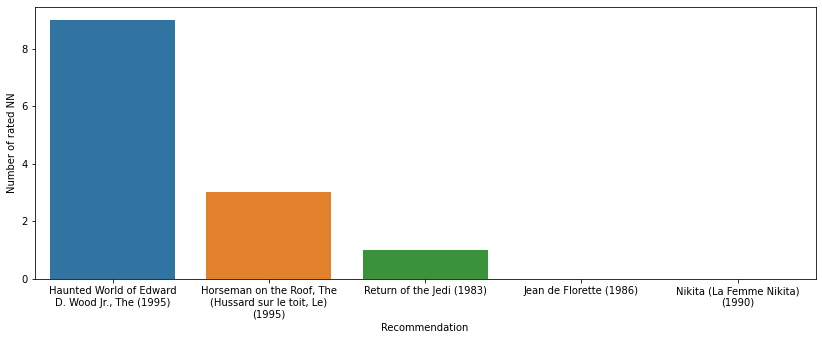

In [ ]:
rated_items = np.nonzero(rating_mat[UIDX])[1]
n_nearest_neighbors = []
for rec in recommendations[:TOPK]:
  nearest_neighbors = np.argsort(iknn_adjusted.sim_mat[rec].A.ravel())[-K:]
  n_nearest_neighbors.append(len(np.intersect1d(nearest_neighbors, rated_items)))
rec_df["Number of rated NN"] = n_nearest_neighbors

fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(x="Recommendation", y="Number of rated NN", data=rec_df, palette="tab10", ax=ax);
ax.set_xticklabels(textwrap.fill(x.get_text(), 25) for x in ax.get_xticklabels());

Trong trường hợp này, đề xuất hàng đầu là  Haunted World of Edward D. Wood Jr., The (1995) và 9 phim trong số 50 phim gần nhất của nó đã được người dùng xếp hạng (có thể đã xem).

# **5. Matrix Factorization**

Hầu hết ma trận đánh giá là ma trận rất thưa thớt. Thách thức sau đó là làm thế nào để điền vào các giá trị còn thiếu một cách chính xác nhất có thể. Nếu chúng ta giả định rằng hầu hết các ma trận đều có biểu diễn bậc thấp (low-rank) (nó có thể được xây dựng lại từ tương đối ít vectơ cơ sở), thì chúng ta có thể tiến hành phân tích ma trận thành nhân tử.

**Dữ liệu mẫu**
Với mục đích minh họa, chúng ta sử dụng một bộ dữ liệu đơn giản bao gồm 5 người dùng và 6 item.

In [ ]:
sample_df = pd.read_csv(
  cache("https://static.preferred.ai/tutorials/recommender-systems/sample_data.csv"), 
  sep=",", names=["UserID", "ItemID", "Rating"]
)
dataset = cornac.data.Dataset.from_uir(sample_df.itertuples(index=False))
R = dataset.matrix.A
R_mask = (R > 0).astype(float)
pd.DataFrame(
  data=R,
  index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
  columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)]
).replace(0, np.nan)

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,7.0,6.0,7.0,4.0,5.0,4.0
User 2,6.0,7.0,NaN,4.0,3.0,4.0
User 3,NaN,3.0,3.0,1.0,1.0,NaN
User 4,1.0,2.0,2.0,3.0,3.0,4.0
User 5,1.0,NaN,1.0,2.0,3.0,3.0


## Singular Value Decomposition (SVD)

Với ma trận đánh giá $ R \in \mathbb{R}^{N \times M} $, SVD tìm kiếm sự phân tách sau:

$$ R = U \Sigma V^T $$

$ U \in \mathbb{R}^{N \times N} $ có các cột trực giao, $ \Sigma \in \mathbb{R}^{N \times M} $ là ma trận chứa $D = \mathrm{min}(N,M)$ singular values $ \sigma_i \geq 0 $ trên đường chéo chính và $ V \in \mathbb{R}^{M \times M} $ có các cột và hàng trực giao.

Hãy thử phân tách ma trận mẫu bằng SVD và tái tạo lại nó chỉ với giá trị số ít đầu tiên.

In [ ]:
U, s, Vt = np.linalg.svd(R, full_matrices=True)
print("Singular values: ", s.round(3))
Sigma = np.zeros((R.shape[0], R.shape[1]))
Sigma[:R.shape[0], :R.shape[0]] = np.diag(s)

N = 1
Sigma = Sigma[:, :N]
Vt = Vt[:N, :]
recon_R = U.dot(Sigma.dot(Vt))

rmse = np.sqrt((((R - recon_R) ** 2) * R_mask).mean())
print(f"\nRMSE = {rmse:.3f}")
print("Reconstructed matrix:")
pd.DataFrame(recon_R.round(2),
             index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
             columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)])

Singular values:  [18.703  5.187  4.537  2.526  0.561]

RMSE = 1.065
Reconstructed matrix:


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,6.44,6.78,4.63,4.79,5.06,5.04
User 2,4.95,5.21,3.56,3.69,3.89,3.87
User 3,1.55,1.63,1.12,1.16,1.22,1.21
User 4,2.78,2.93,2.00,2.07,2.18,2.18
User 5,1.79,1.89,1.29,1.34,1.41,1.40


## **Matrix Factorization (MF)**

Trong phép phân tích ma trận, một ma trận đánh giá thưa thớt $R \in \mathbb{R}^{N \times M}$, cho $N$ người dùng and $M$ items, được nhân tử hóa thành ma trận $U \in \mathbb{R}^{N \times K}$ và ma trận $V \in \mathbb{R}^{M \times K}$, như sau:

$$ R = UV^T $$

Mỗi hàng của $U$ (hoặc $V$) được gọi là *factors* tiềm ẩn của người dùng (hoặc item). Mô hình MF trong Cornac được triển khai để sử dụng *stochastic gradient descent* để tối ưu hóa.


Hãy thử tính hệ số của ma trận mẫu bằng cách sử dụng MF với $K=1$.

In [ ]:
mf = MF(
  k=1, max_iter=100, learning_rate=0.01, lambda_reg=0.0, use_bias=False, verbose=VERBOSE
).fit(dataset)
print("User factors:\n", mf.u_factors)
print("Item factors:\n", mf.i_factors)

recon_R = np.empty(dataset.matrix.shape)
for u, i in itertools.product(range(recon_R.shape[0]), range(recon_R.shape[1])):
  recon_R[u, i] = mf.score(u, i)

rmse = np.sqrt((((R - recon_R) ** 2) * R_mask).mean())
print(f"\nRMSE = {rmse:.3f}")
print("Reconstructed matrix:")
pd.DataFrame(recon_R.round(2),
             index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
             columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)])

User factors:
 [[-2.9985614]
 [-2.755013 ]
 [-1.1654391]
 [-1.2851777]
 [-1.0606911]]
Item factors:
 [[-2.079843 ]
 [-2.2302248]
 [-2.1763263]
 [-1.446763 ]
 [-1.4925438]
 [-1.5895526]]

RMSE = 0.884
Reconstructed matrix:


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,6.24,6.69,6.53,4.34,4.48,4.77
User 2,5.73,6.14,6.00,3.99,4.11,4.38
User 3,2.42,2.60,2.54,1.69,1.74,1.85
User 4,2.67,2.87,2.80,1.86,1.92,2.04
User 5,2.21,2.37,2.31,1.53,1.58,1.69


**MF với MovieLens 100K dataset**

In [ ]:
K = 100
mf = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.0, use_bias=False,
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")
  
data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[mf], metrics=[rmse]).run()


TEST:
...
          |   RMSE | Train (s) | Test (s)
--------- + ------ + --------- + --------
MF(K=100) | 0.8957 |    0.4561 |   1.4841



**Regularization**

Trong thực tế, ma trận đánh giá thường rất thưa thớt. Một cách tiếp cận phổ biến để giải quyết vấn đề này là sử dụng normalization. Trong MF, chúng ta sử dụng l2-norm.

In [ ]:
K = 100
lbd = 0.01
mf = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=lbd, use_bias=False,
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K},lambda={lbd:.4f})")

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[mf], metrics=[rmse]).run()


TEST:
...
                        |   RMSE | Train (s) | Test (s)
----------------------- + ------ + --------- + --------
MF(K=100,lambda=0.0100) | 0.8943 |    0.2510 |   0.4722



**Bias**

In [ ]:
K = 100
models = [
  BaselineOnly(max_iter=20, learning_rate=0.01, lambda_reg=0.01, verbose=VERBOSE),
  MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, use_bias=False, 
     verbose=VERBOSE, seed=SEED, name=f"MF(K={K})"),
  MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, use_bias=True, 
     verbose=VERBOSE, seed=SEED, name=f"MF(K={K},bias)"),
]

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=models, metrics=[rmse]).run()


TEST:
...
               |   RMSE | Train (s) | Test (s)
-------------- + ------ + --------- + --------
BaselineOnly   | 0.9106 |    0.0103 |   0.4087
MF(K=100)      | 0.8943 |    0.2501 |   0.5184
MF(K=100,bias) | 0.8878 |    0.2356 |   0.4761



## **Non-Negative Matrix Factorization (NMF)**

Một biến thể của hệ số ma trận là hệ số ma trận không âm. Các yếu tố tiềm ẩn bị ràng buộc là không âm.

In [ ]:
nmf = NMF(
  k=1, max_iter=100, learning_rate=0.01, lambda_reg=0.0, verbose=VERBOSE
).fit(dataset)
print("User factors:\n", nmf.u_factors)
print("Item factors:\n", nmf.i_factors)

recon_R = np.empty(dataset.matrix.shape)
for u, i in itertools.product(range(recon_R.shape[0]), range(recon_R.shape[1])):
  recon_R[u, i] = nmf.score(u, i)

rmse = np.sqrt((((R - recon_R) ** 2) * R_mask).mean())
print(f"\nRMSE = {rmse:.3f}")
print("Reconstructed matrix:")
pd.DataFrame(recon_R.round(2),
             index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
             columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)])

User factors:
 [[2.7286026]
 [2.4980955]
 [1.0453327]
 [1.1399945]
 [0.9412434]]
Item factors:
 [[2.1162407]
 [2.2686381]
 [2.1906488]
 [1.4885478]
 [1.552525 ]
 [1.6551698]]

RMSE = 0.920
Reconstructed matrix:


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,5.77,6.19,5.98,4.06,4.24,4.52
User 2,5.29,5.67,5.47,3.72,3.88,4.13
User 3,2.21,2.37,2.29,1.56,1.62,1.73
User 4,2.41,2.59,2.50,1.70,1.77,1.89
User 5,1.99,2.14,2.06,1.40,1.46,1.56


**NMF với MovieLens 100K**

In [ ]:
K = 10
nmf = NMF(k=K, max_iter=200, learning_rate=0.01, lambda_reg=0.01, use_bias=False,
          verbose=VERBOSE, seed=SEED, name=f"NMF(K={K})")
          
data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[nmf], metrics=[rmse]).run()


TEST:
...
          |   RMSE | Train (s) | Test (s)
--------- + ------ + --------- + --------
NMF(K=10) | 1.0196 |    2.3609 |   0.9352



## **Giải thích kết quả**

Để hiểu được hoạt động bên trong của các kỹ thuật phân tích ma trận, chúng ta hãy xem làm thế nào các yếu tố tiềm ẩn có thể cung cấp cho chúng ta một số thông tin về cách các mục được liên kết với nhau, cũng như các mục nào có xu hướng được liên kết với một yếu tố cụ thể.

Hãy huấn luyện lại hai mô hình MF và NMF với 10 nhân tố tiềm ẩn và so sánh RMSE của chúng. Có sự khác biệt nào không? Tại sao?

In [ ]:
K = 10
mf = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, use_bias=False, 
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")
nmf = NMF(k=K, max_iter=200, learning_rate=0.01, lambda_reg=0.01, use_bias=False, 
          verbose=VERBOSE, seed=SEED, name=f"NMF(K={K})")
  
data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[mf, nmf], metrics=[rmse]).run()


TEST:
...
          |   RMSE | Train (s) | Test (s)
--------- + ------ + --------- + --------
MF(K=10)  | 0.9027 |    0.0664 |   0.5090
NMF(K=10) | 1.0196 |    1.1587 |   0.5333



**MF**

Dưới đây là phương sai của từng thứ nguyên tiềm ẩn trên các item khác nhau. Nếu một yếu tố hoặc thứ nguyên có phương sai cao hơn, thì việc phân biệt giữa các item khác nhau sẽ tốt hơn. Ngược lại, nếu phương sai của một yếu tố quá nhỏ, điều đó có nghĩa là hầu hết các item sẽ có giá trị tương tự cho yếu tố đó.

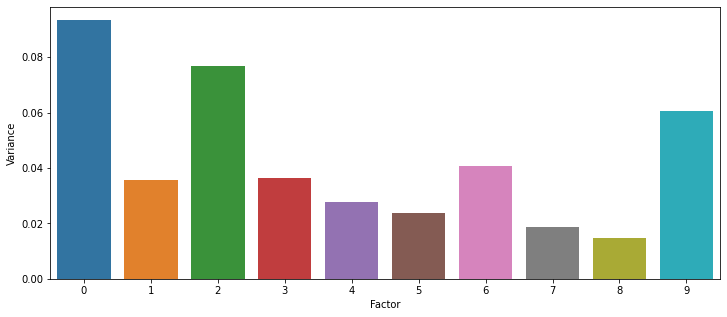

In [ ]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(mf.i_factors, axis=0)})
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="tab10", ax=ax);

**NMF**

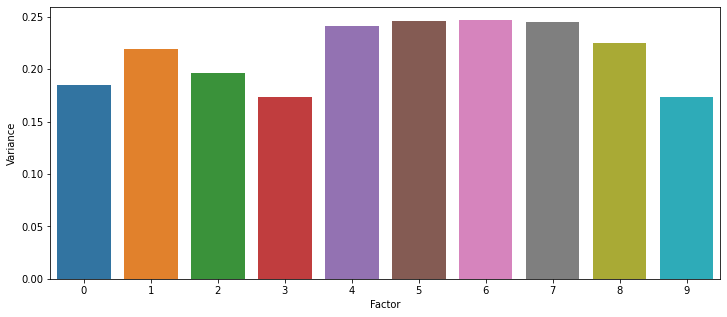

In [ ]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(nmf.i_factors, axis=0)})
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="tab10", ax=ax);

Đối với mỗi yếu tố tiềm ẩn, chúng ta chọn 100 phim hàng đầu có giá trị cao nhất cho yếu tố đó. Sau đó, chúng tôi phân loại chúng thành các thể loại tương ứng. Điều này gợi ý liệu có mối quan hệ hoặc mối liên hệ nào giữa các yếu tố tiềm ẩn và thể loại phim hay không.

In [ ]:
item_idx2id = list(nmf.train_set.item_ids)
top_genres = {}
for k in range(K):
  top_inds = np.argsort(nmf.i_factors[:, k])[-100:]
  top_items = item_df.loc[[int(item_idx2id[i]) for i in top_inds]]
  top_genres[f"Factor {k}"] = top_items.drop(columns=["Title", "Release Date"]).sum(axis=0)
pd.DataFrame(top_genres)

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
Action,18,11,12,17,12,7,4,5,20,15
Adventure,12,4,11,3,5,3,6,2,13,11
Animation,0,1,1,5,3,2,5,0,0,3
Children's,5,3,6,5,5,5,2,2,8,20
Comedy,27,29,31,36,22,32,33,28,24,38
Crime,7,9,5,9,4,3,6,4,9,3
Documentary,3,10,1,3,1,6,4,3,2,3
Drama,39,42,45,43,49,50,55,60,45,30
Fantasy,0,1,1,0,1,1,0,0,1,2
Film-Noir,1,0,0,3,2,1,0,1,0,1


**Tài liệu tham khảo**

1.   Aggarwal, C. C. (2016). Recommender systems (Vol. 1). Cham: Springer International Publishing.
2.   Breese, J. S., Heckerman, D., & Kadie, C. (2013). Empirical analysis of predictive algorithms for collaborative filtering. arXiv preprint arXiv:1301.7363.
3.   Sarwar, B., Karypis, G., Konstan, J., & Riedl, J. (2001, April). Item-based collaborative filtering recommendation algorithms. In Proceedings of the 10th international conference on World Wide Web (pp. 285-295).
4.   Koren, Y., Bell, R., & Volinsky, C. (2009). Matrix factorization techniques for recommender systems. Computer, 42(8), 30-37.
5.   Lee, D. D., & Seung, H. S. (2001). Algorithms for non-negative matrix factorization. In Advances in neural information processing systems (pp. 556-562).